In [342]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [343]:
N_REPETITIONS = 10
N_ITERATIONS = 25
FPS_VALUES = [10, 12, 14, 15, 17, 20]
base_path = "data/ronin/rs"

In [344]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [345]:

def make_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", "rs", rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep)
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

In [346]:
df = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
df = df.xs("True", level='highquality', drop_level=False)
# df.to_csv("df.csv")
df.reset_index().value_counts('route_id')

route_id
RouteScenario_650    24
RouteScenario_421    18
RouteScenario_296    16
RouteScenario_173    16
RouteScenario_187    14
RouteScenario_266    14
RouteScenario_14     13
RouteScenario_245    13
RouteScenario_428    12
RouteScenario_204    12
RouteScenario_237    12
RouteScenario_123    12
RouteScenario_335    12
RouteScenario_110    12
RouteScenario_524    11
RouteScenario_667    11
RouteScenario_457    11
RouteScenario_154    11
RouteScenario_43     10
RouteScenario_682    10
RouteScenario_677    10
RouteScenario_700    10
RouteScenario_27     10
RouteScenario_248    10
RouteScenario_615    10
RouteScenario_534    10
RouteScenario_722     9
RouteScenario_185     9
RouteScenario_725     9
RouteScenario_178     9
RouteScenario_741     9
RouteScenario_213     9
RouteScenario_133     9
RouteScenario_586     9
RouteScenario_718     9
RouteScenario_701     8
RouteScenario_17      8
RouteScenario_491     8
RouteScenario_460     8
RouteScenario_416     8
RouteScenario_258     7
RouteSc

In [347]:
def do_boxplot(df, column, ax=None):
    agg = df.groupby(["fps", "rep"])[column].mean()
    # use index as possition for correct spacing
    pos = agg.reset_index().groupby('fps')[column].mean().index
    agg.reset_index().boxplot(by='fps', column=column, ax=ax,
                              grid=True, positions=pos, widths=0.8)

## SOLUTIONS

In [348]:
# Get an index of minimal driving score for each fidelity value for each repetition
solutions_idx = df.groupby(
    ['fps', 'highquality', 'rep'],)['driving_score'].idxmin()
solutions = df.loc[solutions_idx][['driving_score', 'duration_system']]
solutions

driving_score  duration_system
fps highquality rep it route_id                                         
10  True        0   2  RouteScenario_476       0.051906       715.298356
                1   8  RouteScenario_11        0.037047       446.656913
                2   13 RouteScenario_72        0.064589       503.555820
                3   6  RouteScenario_277       0.036114       456.751542
                4   2  RouteScenario_533       0.008751       375.343144
                5   8  RouteScenario_419       0.014509       474.186526
                6   23 RouteScenario_140       0.037832      2480.073235
                7   21 RouteScenario_691       0.029512       600.963824
                8   2  RouteScenario_532       0.020712       339.691378
                9   7  RouteScenario_335       0.040281       439.234951
12  True        0   1  RouteScenario_297       0.063168      1130.409332
                1   0  RouteScenario_109       0.043124       425.396270
                2   4  RouteScenario_161       0.027361      1513.066259
                3   8  RouteScenario_419       0.010590      1710.135536
                4   2  RouteScenario_310       0.066807       761.825678
                5   20 RouteScenario_534       0.031864       344.336285
                6   2  RouteScenario_532       0.049022       326.518406
                7   23 RouteScenario_324       0.074381       445.223487
                8   6  RouteScenario_490       0.107677      3991.772129
                9   1  RouteScenario_248       0.008072       456.960741
14  True        0   4  RouteScenario_161       0.054426      1721.343493
                1   2  RouteScenario_492       0.035957      4352.792101
                2   2  RouteScenario_310       0.066807       886.837375
                3   4  RouteScenario_342       0.033464      1014.618071
                4   11 RouteScenario_151       0.110246      2027.125022
                5   23 RouteScenario_324       0.076381       513.142357
                6   13 RouteScenario_241       0.140798      1087.268645
                7   1  RouteScenario_248       0.007640       519.538184
                8   0  RouteScenario_296       0.047640      1309.676133
                9   1  RouteScenario_392       0.004505       526.392623
15  True        0   17 RouteScenario_309       0.100493       969.201489
                1   2  RouteScenario_310       0.066807       941.299129
                2   4  RouteScenario_342       0.022467      1035.099929
                3   18 RouteScenario_274       0.149428       615.170724
                4   23 RouteScenario_324       0.078777       515.177018
                5   13 RouteScenario_241       0.234663      1115.644928
                6   1  RouteScenario_248       0.008072       529.093304
                7   12 RouteScenario_273       0.058740       960.750967
                8   1  RouteScenario_392       0.004505       527.569349
                9   7  RouteScenario_261       0.112687       893.265387
17  True        0   5  RouteScenario_245       0.110324      1162.162435
                1   9  RouteScenario_296       0.081464      1472.350468
                2   18 RouteScenario_594       0.169849       600.960851
                3   6  RouteScenario_490       0.106772      5314.691219
                4   1  RouteScenario_248       0.007640       590.788651
                5   12 RouteScenario_273       0.058740      1074.184078
                6   1  RouteScenario_392       0.004505       613.257451
                7   15 RouteScenario_589       0.140986       606.393085
                8   17 RouteScenario_248       0.007640       592.533427
                9   16 RouteScenario_245       0.110324      1175.299642
18  True        0   9  RouteScenario_296       0.081464      1519.697534
                1   18 RouteScenario_594       0.169849       624.531777
                2   17 RouteScenario_599       0.480000       360.940679
                3   1  Rout

## VERIFICATION

In [349]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [350]:
dfs = []
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]

# deduplicate
oracle_df = oracle_df.groupby(oracle_df.index).last()
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
# oracle_df

In [351]:
joined = solutions.join(oracle_df)


joined['rmse'] = (joined['oracle_dscore'] -
                  joined['driving_score']).pow(2.0).pow(0.5)

joined

driving_score  duration_system  oracle_dscore      rmse
fps highquality rep it route_id                                                                  
10  True        0   2  RouteScenario_476       0.051906       715.298356       1.000000  0.948094
                1   8  RouteScenario_11        0.037047       446.656913       0.710977  0.673930
                2   13 RouteScenario_72        0.064589       503.555820       1.000000  0.935411
                3   6  RouteScenario_277       0.036114       456.751542       1.000000  0.963886
                4   2  RouteScenario_533       0.008751       375.343144       1.000000  0.991249
                5   8  RouteScenario_419       0.014509       474.186526       1.000000  0.985491
                6   23 RouteScenario_140       0.037832      2480.073235       0.109454  0.071623
                7   21 RouteScenario_691       0.029512       600.963824       1.000000  0.970488
                8   2  RouteScenario_532       0.020712       339.691378       1.000000  0.979288
                9   7  RouteScenario_335       0.040281       439.234951       1.000000  0.959719
12  True        0   1  RouteScenario_297       0.063168      1130.409332       0.292444  0.229276
                1   0  RouteScenario_109       0.043124       425.396270       0.700000  0.656876
                2   4  RouteScenario_161       0.027361      1513.066259       1.000000  0.972639
                3   8  RouteScenario_419       0.010590      1710.135536       1.000000  0.989410
                4   2  RouteScenario_310       0.066807       761.825678       0.059617  0.007190
                5   20 RouteScenario_534       0.031864       344.336285       1.000000  0.968136
                6   2  RouteScenario_532       0.049022       326.518406       1.000000  0.950978
                7   23 RouteScenario_324       0.074381       445.223487       1.000000  0.925619
                8   6  RouteScenario_490       0.107677      3991.772129       0.441937  0.334260
                9   1  RouteScenario_248       0.008072       456.960741       0.007640  0.000432
14  True        0   4  RouteScenario_161       0.054426      1721.343493       1.000000  0.945574
                1   2  RouteScenario_492       0.035957      4352.792101       0.443303  0.407346
                2   2  RouteScenario_310       0.066807       886.837375       0.059617  0.007190
                3   4  RouteScenario_342       0.033464      1014.618071       0.600000  0.566536
                4   11 RouteScenario_151       0.110246      2027.125022       0.304494  0.194248
                5   23 RouteScenario_324       0.076381       513.142357       1.000000  0.923619
                6   13 RouteScenario_241       0.140798      1087.268645       0.660683  0.519885
                7   1  RouteScenario_248       0.007640       519.538184       0.007640  0.000000
                8   0  RouteScenario_296       0.047640      1309.676133       0.345305  0.297665
                9   1  RouteScenario_392       0.004505       526.392623       0.004505  0.000000
15  True        0   17 RouteScenario_309       0.100493       969.201489       0.093169  0.007324
                1   2  RouteScenario_310       0.066807       941.299129       0.059617  0.007190
                2   4  RouteScenario_342       0.022467      1035.099929       0.600000  0.577533
                3   18 RouteScenario_274       0.149428       615.170724       0.149428  0.000000
                4   23 RouteScenario_324       0.078777       515.177018       1.000000  0.921223
                5   13 RouteScenario_241       0.234663      1115.644928       0.660683  0.426020
                6   1  RouteScenario_248       0.008072       529.093304       0.007640  0.000432
                7   12 RouteScenario_273       0.058740       960.750967       0.052178  0.006562
                8   1  RouteScenario_392       0.004505       527.569349       0.004505  0.000000
                9   7  R

## FIGURES

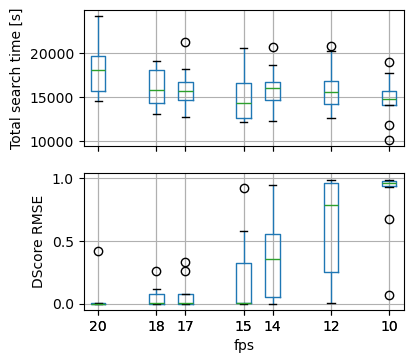

In [352]:
fig, ax = plt.subplots(nrows=2, squeeze=True, sharex=True)
fig.set_size_inches(4, 4)

# BOX PLOT FOR TOTAL TIME
total_time = df.groupby(
    ['fps', 'rep', ])['duration_system'].sum()

pos = total_time.reset_index().groupby('fps')['duration_system'].mean().index

total_time.reset_index().boxplot(by='fps', positions=pos,
                                 column='duration_system', ax=ax[0])


ax[0].set_ylabel(f"Total search time [s]")
ax[0].set_title("")
ax[0].set_xlabel("")

ax[0].invert_xaxis()

# BOX PLOT FOR RMSE

rmse = joined.groupby(['fps', 'rep', ])['rmse'].mean()

rmse.reset_index().boxplot(by='fps', positions=pos,
                           column='rmse', ax=ax[1])

ax[1].set_ylabel(f"DScore RMSE")
ax[1].set_title("")
fig.suptitle('')

fig.savefig('rs_boxplot.pdf', bbox_inches='tight')

## Number of diffrent scenarios

In [353]:
joined.reset_index().groupby('fps').value_counts(
    subset=['route_id']).reset_index()

sets = joined.reset_index().groupby('fps')['route_id'].apply(set)

oracle_set = sets.loc[20]
sets = sets.apply(lambda set_x: len(set_x.intersection(oracle_set)))
sets

fps
10    0
12    2
14    2
15    4
17    4
18    4
20    8
Name: route_id, dtype: int64

## Similarity of diffrent scenarios